In [2]:
# import data handling libraries
import pandas as pd
import numpy as np
# import graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
# import stats libraries
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson, norm, chi2, ttest_ind, ttest_rel
from scipy import stats
from scipy import fft
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.express as px
# from sklearn.cluster import AgglomerativeClustering


Initialisation function 

In [3]:
columns = [
    'Unique Meter ID', 
    'Unix Time Stamp', 
    'Date/Time Stamp', 
    'Incremental Consumption Value (Gallons)', 
    'Reading Value (Gallons)'
]
df = pd.read_csv("/Users/derekzheng/Documents/coding/r42/Sample_UtilityX_AMIData.csv", 
#                      names=columns, 
    header=None,
    index_col=False 
  )
 
df = df.loc[:,[0,1,2,3,4]]
df.columns = columns
df.head()

,Unique Meter ID,Unix Time Stamp,Date/Time Stamp,Incremental Consumption Value (Gallons),Reading Value (Gallons)
0,31793811,1489240800,2017-03-11 14:00:00,30,1049109.9
1,31793811,1489244400,2017-03-11 15:00:00,20,1049128.9
2,31793811,1489248000,2017-03-11 16:00:00,10,1049139.9
3,31793811,1489251600,2017-03-11 17:00:00,10,1049149.9
4,31793811,1489255200,2017-03-11 18:00:00,10,1049159.9


In [4]:
dataframe = df

Converting to datetime module

In [5]:
# convert datatype to datetime
""" This function converts the date and time to datetime datatype
It requires two inputs:
   the first being the dataframe 
   the second being the name of the time column in string format e.g. 'date'
"""
def convert_to_datetime(df, time_col):
    df[time_col] = pd.to_datetime(df[time_col])
    df['dotw'] = df['Date/Time Stamp'].dt.dayofweek
    df['hour'] = df['Date/Time Stamp'].dt.hour
    df['doty'] = df['Date/Time Stamp'].dt.dayofyear
    return df

In [6]:
convert_to_datetime(df, 'Date/Time Stamp')

,Unique Meter ID,Unix Time Stamp,Date/Time Stamp,Incremental Consumption Value (Gallons),Reading Value (Gallons),dotw,hour,doty
0,31793811,1489240800,2017-03-11 14:00:00,30,1049109.9,5,14,70
1,31793811,1489244400,2017-03-11 15:00:00,20,1049128.9,5,15,70
2,31793811,1489248000,2017-03-11 16:00:00,10,1049139.9,5,16,70
3,31793811,1489251600,2017-03-11 17:00:00,10,1049149.9,5,17,70
4,31793811,1489255200,2017-03-11 18:00:00,10,1049159.9,5,18,70
...,...,...,...,...,...,...,...,...
2590320,34071091,1488744000,2017-03-05 20:00:00,430,20518299.0,6,20,64
2590321,34071091,1488747600,2017-03-05 21:00:00,430,20518723.0,6,21,64
2590322,34071091,1488751200,2017-03-05 22:00:00,430,20519159.0,6,22,64
2590323,34071091,1488754800,2017-03-05 23:00:00,430,20519589.0,6,23,64


In [7]:
def make_timestamps(df, meter_col, date_col):
    meters = df[meter_col].unique() # get all unique meters
    dates = df[date_col].unique() # get all unique datetime points

    # create df with all possible datetime points for each meter
    # set columns for new df
    df_temp = pd.DataFrame(np.array(np.meshgrid(meters, dates)).T.reshape(-1,2)) 
    df_temp.columns = [meter_col, date_col] 

    df_temp[date_col] = pd.to_datetime(df_temp[date_col]) # change datatype
    df_new = df_temp.merge(df, how = 'left') #merge with original dataframe to give NaN read values where data is missing 
    df_new = df_new.sort_values([meter_col, date_col])
    df_new = df_new.reset_index()

    del df_temp
    return df_new

def add_periodic_time_columns(df, date_col):
    df['dotw'] = df[date_col].dt.dayofweek
    df['hour'] = df[date_col].dt.hour
    df['doty'] = df[date_col].dt.dayofyear
    return df

def interpolate_missing_reads(df, meter_col, date_col, reads_col, nan_timestamps=True):
    if nan_timestamps != True:
        df_temp = make_timestamps(df, meter_col, date_col)
    else:
        df_temp = df

    df_temp = df_temp.sort_values([meter_col, date_col])
    df_temp = df_temp.reset_index()

    df_temp.loc[:, [reads_col]]

    df_interp = df_temp.interpolate(
        method='spline',
        limit_direction='both',
        limit_area='inside',
        order=1
    )
    return df_interp


In [8]:
df1 = make_timestamps(df, 'Unique Meter ID', 'Date/Time Stamp')

In [9]:
df_test = df1.loc[df1['Unique Meter ID'] == 31793811]

In [10]:
# display(df_test.count())
# df_temp = interpolate_missing_reads(df_test, 'Unique Meter ID', 'Date/Time Stamp', 'Reading Value (Gallons)', nan_timestamps=True)
# df_temp.count()

In [11]:
df1.shape

(5966241, 9)

In [12]:
df1.loc[(df1['Unique Meter ID'] == 23385775)&~(df1['Incremental Consumption Value (Gallons)'].isna())]

,index,Unique Meter ID,Date/Time Stamp,Unix Time Stamp,Incremental Consumption Value (Gallons),Reading Value (Gallons),dotw,hour,doty
237258,215297,23385775,2017-01-30 15:00:00,1.485788e+09,0.0,1332100.0,0.0,15.0,30.0
237259,215298,23385775,2017-01-30 16:00:00,1.485792e+09,0.0,1332100.0,0.0,16.0,30.0
237260,215299,23385775,2017-01-30 17:00:00,1.485796e+09,0.0,1332100.0,0.0,17.0,30.0
237261,215300,23385775,2017-01-30 18:00:00,1.485799e+09,0.0,1332100.0,0.0,18.0,30.0
237262,215301,23385775,2017-01-30 19:00:00,1.485803e+09,0.0,1332100.0,0.0,19.0,30.0
...,...,...,...,...,...,...,...,...,...
240918,218057,23385775,2017-07-02 03:00:00,1.498964e+09,100.0,1353100.0,6.0,3.0,183.0
240919,218058,23385775,2017-07-02 04:00:00,1.498968e+09,0.0,1353100.0,6.0,4.0,183.0
240920,218059,23385775,2017-07-02 05:00:00,1.498972e+09,0.0,1353100.0,6.0,5.0,183.0
240921,218060,23385775,2017-07-02 06:00:00,1.498975e+09,0.0,1353100.0,6.0,6.0,183.0


In [ ]:
dfs = []
df_base = []
i = 1

# print("values: ", df1['Unique Meter ID'].unique())
# s factor for cubic spline -> change it with the :30 OR use interpolate directly not the wrapper
# first and last -> find a linear reg of the data and then you subtract the baseline
# always need to preserve monotonic increasing
#how to make it monotonic increasing with the linear fit taken out 
# normalize the data? idk
for meter in df1['Unique Meter ID'].unique():
    if i == 1:
        df_base = df1.loc[df1['Unique Meter ID'] == meter]
        df_base = interpolate_missing_reads(df_base, 'Unique Meter ID', 'Date/Time Stamp', 'Reading Value (Gallons)', nan_timestamps=True)
        i += 1
    else: 
        # if i % 10 == 0:
        if i == 28 or i == 27:
            # print(df_base)
            print("skipped ", meter)
            i += 1
            continue
        print(i, " - ", meter)
        df_temp = df1.loc[df1['Unique Meter ID'] == meter]
        # df_temp = interpolate_missing_reads(df_temp, 'Unique Meter ID', 'Date/Time Stam
        df_temp = interpolate_missing_reads(df_temp, 'Unique Meter ID', 'Date/Time Stamp', 'Reading Value (Gallons)', nan_timestamps=True)
        df_temp.to_csv('output.csv', mode='a')
        df_base = pd.concat([df_base, df_temp])
        del df_temp
        print(" - ")
        i += 1

In [16]:
df_base.to_csv('Sample_Interpolation_Trial1_2020-09-.csv')

Text(0.5, 1.0, 'Filled missing values for n=90 meters')

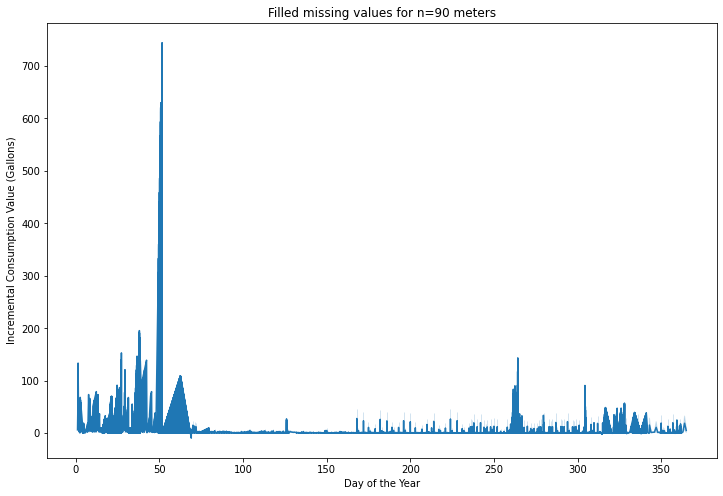

In [18]:
# Yearly cycle
# raw_df.groupby(['doty']).\
        # agg({'Incremental Consumption Value (Gallons)':'mean'}).plot()
fig, ax = plt.subplots(1, figsize=(12,8))
sns.lineplot(
    x='doty',
    y='Incremental Consumption Value (Gallons)',
    data=df_base
)
# plt.ylabel('')
plt.xlabel('Day of the Year')
plt.title('Filled missing values for n=90 meters')


# # plt.ylim(0,130)